<a href="https://colab.research.google.com/github/avpai-dinosaur/gender_classification/blob/main/reu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries.

In [ ]:
import os
import PIL
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

Load the image data sets. We are using the [GENDER-COLOR-FERET dataset](https://mivia.unisa.it/datasets/video-analysis-datasets/gender-recognition-dataset/) from Mivia Lab of the University of Salerno. This is a balanced subset of the COLOR-FERET dataset, adapted for gender recogntion purposes. In this case the images are coloured and the dataset is composed by 836 faces. The dataset is completely balanced, since both the training and the test set are composed of 209 male and 209 female faces.

Uploaded the dataset as zip file to Google Drive and unzipped.

In [ ]:
# !unzip -uq "/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET.zip" -d "/content/drive/MyDrive/(8) Summer 2023 REU"

In [ ]:
# put path to dataset in this variable
DATASET_PATH = "/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET"

(!! Files already renamed so don't need to run this again !!) Renaming the file to number the images in order in a consistent format.

In [ ]:
def name_file_number(num):
  num = str(num)
  if len(num) == 1:
    return "000" + num
  elif len(num) == 2:
    return "00" + num
  else:
    return "0" + num

def rename_images():
  dataset_directory = DATASET_PATH
  num_images = 0
  for test_train_split in os.listdir(dataset_directory):
    for gender in os.listdir(dataset_directory + "/" + test_train_split):
      for file in os.listdir(dataset_directory + "/" + test_train_split + "/" + gender):
        new_filename = name_file_number(num_images) + ".jpg"
        os.rename(dataset_directory + "/" + test_train_split + "/" + gender + "/" + file,
                  dataset_directory + "/" + test_train_split + "/" + gender + "/" + new_filename)
        num_images += 1
  return

# rename_images()


Get the image dimensions and save in a constant variable.

In [ ]:
im = PIL.Image.open(DATASET_PATH + "/training_set/female/0418.jpg")
print(im.size)

(512, 768)


As we can see the original dimensions of the images are very large and result in a long training time. Thus we will preprocess images for some performance by resizing them to 128 x 85 pixels.

In [ ]:
def resize_images(dir, size):
  for file in os.listdir(dir):
    if not file.endswith(".jpg"):
      continue
    im = PIL.Image.open(dir + "/" + file)
    im.thumbnail(size, PIL.Image.ANTIALIAS)
    im.save("/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET-PROCESSED" + "/" + dir + "/" + file[:4] + ".thumbnail.jpg")
    # print("Saving:", "/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET-PROCESSED" + "/" + dir + "/" + file[:4] + ".thumbnail.jpg")
  return

DATASET_PATH = "/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET-PROCESSED"
# os.chdir("/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET")
# resize_images("test_set/female", (256, 384))
# resize_images("training_set/female", (256, 384))
# resize_images("test_set/male", (256, 384))
# resize_images("training_set/male", (256, 384))
# im = PIL.Image.open(DATASET_PATH + "/training_set/female/0418.thumbnail.jpg")
IMAGE_SIZE = (384, 256)
print(IMAGE_SIZE)

(384, 256)


Load training, validation, and testing data using tf.keras utility functions. Generate a 80/20 train/validation split.

In [ ]:
training_set = "/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET-PROCESSED/training_set"
test_set = "/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET-PROCESSED/test_set"
batch_size = 64
train_data = tf.keras.utils.image_dataset_from_directory(
  training_set,
  label_mode="binary",
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMAGE_SIZE,
  batch_size=batch_size)

validation_data = tf.keras.utils.image_dataset_from_directory(
  training_set,
  label_mode="binary",
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMAGE_SIZE,
  batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
  test_set,
  label_mode="binary",
  seed=123,
  shuffle=True,
  image_size=IMAGE_SIZE,
  batch_size=batch_size)

Found 418 files belonging to 2 classes.
Using 335 files for training.
Found 418 files belonging to 2 classes.
Using 83 files for validation.
Found 419 files belonging to 2 classes.


['female', 'male']


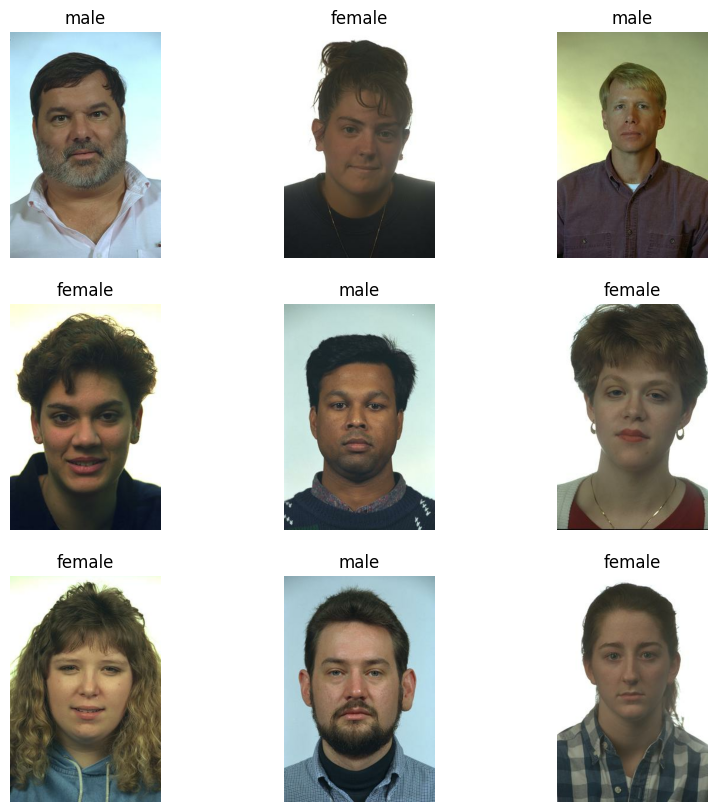

In [ ]:
class_names = train_data.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = labels[i].numpy().astype("uint8")
    plt.title(class_names[label[-1]])
    plt.axis("off")

Configure the dataset for performance based on documentation. Don't totally understand this but it has something to do with avoiding I/O blocking when loading batches from the disk.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
validation_datas = validation_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

# Model Training

Load a pre-trained EfficientNetV2B0 classifier to use as a feature extractor. This is a convolutional network trained on the ImageNet dataset, so we hypothesize that it is a good feature extractor for an image classification task.





In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                               weights="imagenet",
                                               input_shape=IMAGE_SIZE + (3,))

image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print("Feature extraction dimensions:", feature_batch.shape)

16705208/16705208 [==============================] - 0s 0us/step
Feature extraction dimensions: (64, 12, 8, 1280)


Next we freeze the weights of the base model. As we can see from the model summary there are no trainable parameters.

In [ ]:
base_model.trainable = False
# base_model.summary()

Now we add our top layers to the base model which will allow us to make predictions.

1.   Base Model
2.   Global Average Layer (to flatten features into 1-D vector)
3.   final Dense prediction layer



In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

x = global_average_layer(base_model.output)
outputs = prediction_layer(x)
model = tf.keras.Model(base_model.input, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
# model.summary()

Train the model on the training data and evaluate on the heldout test set.

In [ ]:
# model.fit(train_data, validation_data=validation_data, epochs=10)
# model.evaluate(test_data)

In [ ]:
# Save the entire model as a SavedModel.
os.chdir("/content/drive/MyDrive/(8) Summer 2023 REU")
# os.mkdir("saved_model")
# model.save_weights('saved_model/my_model_weights.h5')

In [ ]:
os.chdir("/content/drive/MyDrive/(8) Summer 2023 REU")

x = global_average_layer(base_model.output)
outputs = prediction_layer(x)
new_model = tf.keras.Model(base_model.input, outputs)
new_model.load_weights('saved_model/my_model_weights.h5')

base_learning_rate = 0.0001
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
new_model.evaluate(test_data)

7/7 [==============================] - 110s 9s/step - loss: 0.4347 - binary_accuracy: 0.8182


[0.4346511662006378, 0.8181818127632141]

#  Fine Tuning

We'll first unfreeze the top layers of the model.

In [ ]:
base_model.trainable = True
print("Number of layers in base model:", len(base_model.layers))
fine_tune_at = 235

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
# new_model.fit(train_data, validation_data=validation_data, epochs=10)
new_model.evaluate(test_data)

Number of layers in base model: 238
7/7 [==============================] - 72s 9s/step - loss: 0.3856 - binary_accuracy: 0.8804


[0.3855816721916199, 0.880382776260376]

In [ ]:
os.chdir("/content/drive/MyDrive/(8) Summer 2023 REU")
# new_model.save_weights("saved_model/fine_tuning_weights.h5")


# Load final model

We load our fine-tuned model from pretrained weights. Evaluating on the test set we see we have 88% accuracy.

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                               weights="imagenet",
                                               input_shape=IMAGE_SIZE + (3,))
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

x = global_average_layer(base_model.output)
outputs = prediction_layer(x)
final_model = tf.keras.Model(base_model.input, outputs)
final_model.load_weights("/content/drive/MyDrive/(8) Summer 2023 REU/saved_model/fine_tuning_weights.h5")

base_learning_rate=0.0001
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
final_model.evaluate(test_data)


7/7 [==============================] - 95s 9s/step - loss: 0.3859 - binary_accuracy: 0.8807


[0.38590681552886963, 0.8806682825088501]

# Grad-CAM Visualization

The Grad-CAM algorithm.

In [ ]:
def get_image_array(img_path):
  im = PIL.Image.open(img_path)
  # `array` is a float32 Numpy array of shape (128, 86, 3)
  array = tf.keras.utils.img_to_array(im)
  # add dimension to transform array into a "batch" of size (1, 299, 299, 3)
  array = np.expand_dims(array, axis=0)
  return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Test the heatmap on a sample image.

In [ ]:
last_conv_layer_name = "top_conv"

1/1 [==============================] - 2s 2s/step
Predicted: [0]


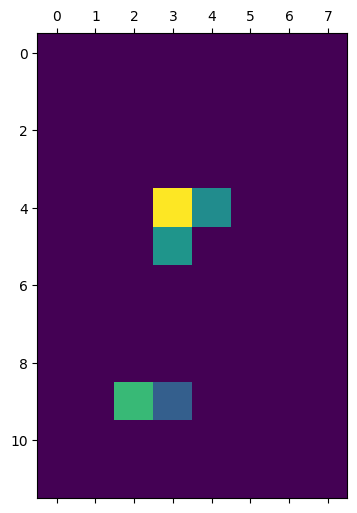

In [ ]:
img_path = "/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET-PROCESSED/test_set/female/0206.thumbnail.jpg"
img_array = get_image_array(img_path)
img_array = np.flip(img_array, axis=2)

# Print what the top predicted class is
preds = final_model.predict(img_array).flatten()
preds = tf.nn.sigmoid(preds)
preds = tf.where(preds < 0.5, 0, 1)

print("Predicted:", preds.numpy())

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, final_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Superimpose heatmap onto image.

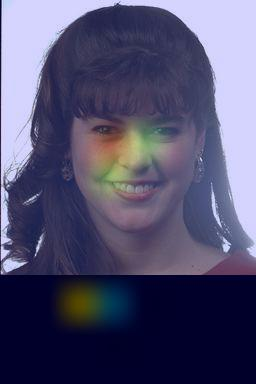

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4, flip=False, black_out=False):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)
    height, width, num_channels = np.shape(img)

    if flip:
      img = np.flip(img, axis=1)

    if black_out:
      for channel in range(3):
        for row in range(height - int(height / 3.5), height):
          for col in range(width):
            img[row][col][channel] = 0

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap, flip=False, black_out=(True, 3.5))

In [ ]:
def save_gradcams(dir, model, last_conv_layer_name):
  for file in os.listdir(dir):
    # Get the prediction of the image
    img_array = get_image_array(dir + "/" + file)
    pred = model.predict(img_array).flatten()
    pred = tf.nn.sigmoid(pred)
    pred = tf.where(pred < 0.5, 0, 1)

    # construct the heatmap of the image
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # determine whether the inage was classified correctly
    if dir == "female":
      if pred[0] == 0:
        print(file, "classified correctly")
        save_and_display_gradcam(img_path=dir + "/" + file, heatmap=heatmap,
                             cam_path="/content/drive/MyDrive/(8) Summer 2023 REU/Grad-CAMs/correct/" + dir + "/" + file[:4] + ".cam.jpg")
      else:
        print(file, "misclassified")
        save_and_display_gradcam(img_path=dir + "/" + file, heatmap=heatmap,
                             cam_path="/content/drive/MyDrive/(8) Summer 2023 REU/Grad-CAMs/misclassified/" + dir + "/" + file[:4] + ".cam.jpg")
    elif dir == "male":
      if pred[0] == 1:
        print(file, "classified correctly")
        save_and_display_gradcam(img_path=dir + "/" + file, heatmap=heatmap,
                             cam_path="/content/drive/MyDrive/(8) Summer 2023 REU/Grad-CAMs/correct/" + dir + "/" + file[:4] + ".cam.jpg")
      else:
        print(file, "misclassified")
        save_and_display_gradcam(img_path=dir + "/" + file, heatmap=heatmap,
                             cam_path="/content/drive/MyDrive/(8) Summer 2023 REU/Grad-CAMs/misclassified/" + dir + "/" + file[:4] + ".cam.jpg")
  return

os.chdir("/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET-PROCESSED/test_set")
# save_gradcams("female", final_model, last_conv_layer_name)
# save_gradcams("male", final_model, last_conv_layer_name)

# Experiments

We first observe that the classifier misgenders women more than men.

In [ ]:
num_misclassified_women = len(os.listdir("/content/drive/MyDrive/(8) Summer 2023 REU/Grad-CAMs/misclassified/female"))
print("number of misclassified women:", num_misclassified_women)
num_misclassified_men = len(os.listdir("/content/drive/MyDrive/(8) Summer 2023 REU/Grad-CAMs/misclassified/male"))
print("number of misclassified men:", num_misclassified_men)

number of misclassified women: 33
number of misclassified men: 10


Based on heatmaps hypothesize that women are being classified based on lacking male traits while men are being classified based on having male traits.

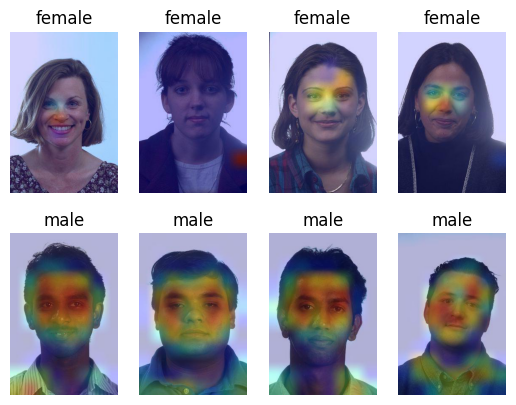

In [ ]:
correct_female = ["0030", "0033", "0036", "0039"]
correct_male = ["0225", "0226", "0227", "0240"]

i = 0
while (i < 8):
  for female in correct_female:
    ax = plt.subplot(2, 4, i + 1)
    im = PIL.Image.open("/content/drive/MyDrive/(8) Summer 2023 REU/Grad-CAMs/correct/female/"
                        + female + ".cam.jpg")
    plt.imshow(im)
    label = "female"
    plt.title("female")
    plt.axis("off")
    if (i > 3):
      break
    i += 1

  for male in correct_male:
    ax = plt.subplot(2, 4, i + 1)
    im = PIL.Image.open("/content/drive/MyDrive/(8) Summer 2023 REU/Grad-CAMs/correct/male/"
                        + male + ".cam.jpg")
    plt.imshow(im)
    label = "male"
    plt.title("male")
    plt.axis("off")
    i += 1




# for images, labels in train_data.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     label = labels[i].numpy().astype("uint8")
#     plt.title(class_names[label[-1]])
#     plt.axis("off")

Women are also being classified on the absence of a collar button or shirt collar.

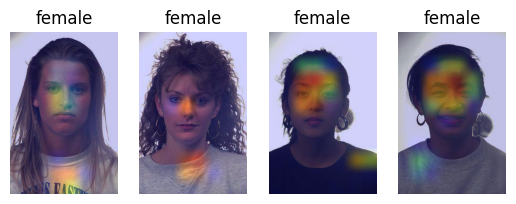

In [ ]:
no_collar_women = ["0047", "0051", "0059", "0060"]
i = 0
while (i < 4):
  for woman in no_collar_women:
    ax = plt.subplot(2, 4, i + 1)
    im = PIL.Image.open("/content/drive/MyDrive/(8) Summer 2023 REU/Grad-CAMs/correct/female/"
                        + woman + ".cam.jpg")
    plt.imshow(im)
    label = "female"
    plt.title("female")
    plt.axis("off")
    if (i > 3):
      break
    i += 1

7 misclassified women (women classified as men) were wearing closed or almost closed collars with buttons clearly visible. In this case the heatmap targetted the buttons.

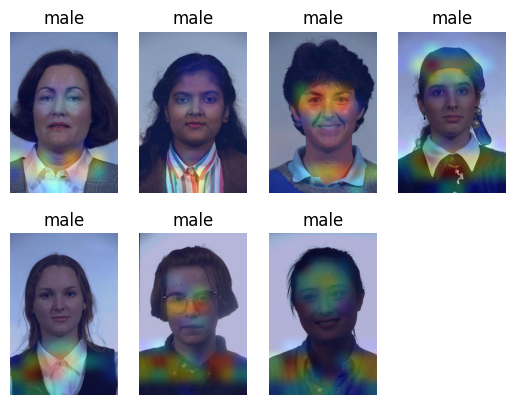

In [ ]:
button_women = ["0164", "0151", "0148", "0143", "0139", "0035", "0031"]
i = 0
while (i < 4):
  for woman in button_women:
    ax = plt.subplot(2, 4, i + 1)
    im = PIL.Image.open("/content/drive/MyDrive/(8) Summer 2023 REU/Grad-CAMs/misclassified/female/"
                        + woman + ".cam.jpg")
    plt.imshow(im)
    label = "female"
    plt.title("male")
    plt.axis("off")
    i += 1

One hypothesis is that women's shirts have buttons on the left and the classifier has observed this. We attempt to verify this hypothesis by flipping the images and seeing predictions.

1/1 [==============================] - 0s 130ms/step
0164 Predicted: [1]


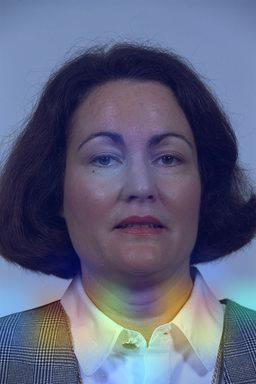

1/1 [==============================] - 0s 131ms/step
0151 Predicted: [1]


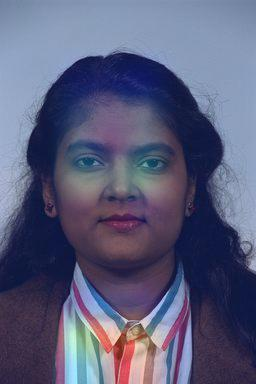

1/1 [==============================] - 0s 130ms/step
0148 Predicted: [1]


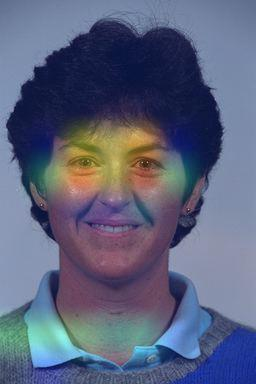

1/1 [==============================] - 0s 137ms/step
0143 Predicted: [1]


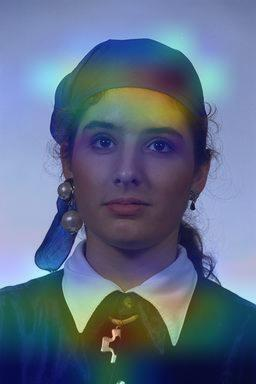

1/1 [==============================] - 0s 134ms/step
0139 Predicted: [1]


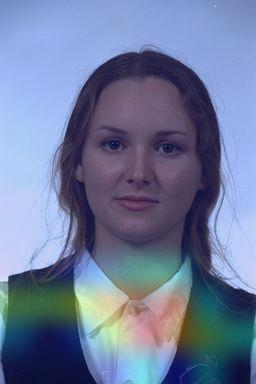

1/1 [==============================] - 1s 646ms/step
0035 Predicted: [1]


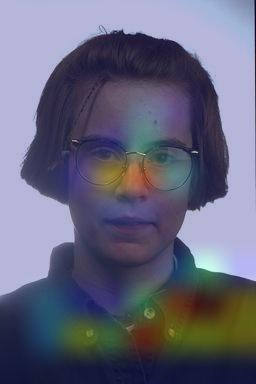

1/1 [==============================] - 0s 176ms/step
0031 Predicted: [1]


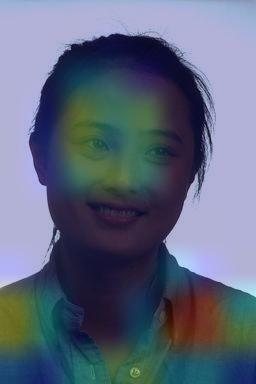

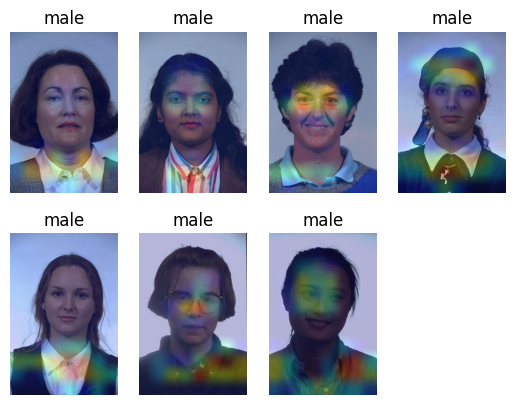

In [ ]:
def flip_button_experiment(button_women):

  os.chdir("/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET-PROCESSED/test_set/female")
  i = 0
  while (i < 4):
    for woman in button_women:
      # Flip the image
      img_path = woman + ".thumbnail.jpg"
      img_array = get_image_array(img_path)
      img_array = np.flip(img_array, axis=2)

      # Print what the top predicted class is
      preds = final_model.predict(img_array).flatten()
      preds = tf.nn.sigmoid(preds)
      preds = tf.where(preds < 0.5, 0, 1)

      print(woman, "Predicted:", preds.numpy())

      heatmap = make_gradcam_heatmap(img_array, final_model, last_conv_layer_name)
      save_and_display_gradcam(img_path, heatmap, flip=True)

      ax = plt.subplot(2, 4, i + 1)
      im = PIL.Image.open("/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET-PROCESSED/test_set/female/cam.jpg")
      plt.imshow(im)

      if preds.numpy()[0] == 1:
        label = "male"
        plt.title("male")
      else:
        label = "female"
        plt.title("female")

      plt.axis("off")
      i += 1

  return

flip_button_experiment(button_women)

All the women are still misclassified so we are lead to believe it is simply the presence of the buttons themselves. To test this we crop out all the buttons and classify again.

(384, 256, 3)
1/1 [==============================] - 0s 173ms/step
0164 Predicted: [0]


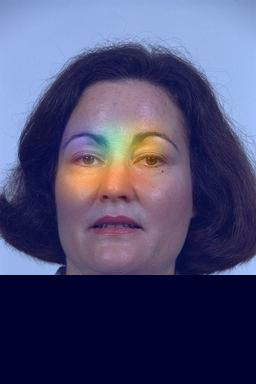

(384, 256, 3)
1/1 [==============================] - 0s 220ms/step
0151 Predicted: [0]


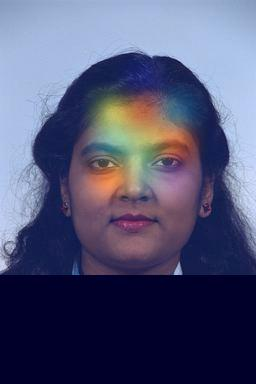

(384, 256, 3)
1/1 [==============================] - 0s 222ms/step
0148 Predicted: [1]


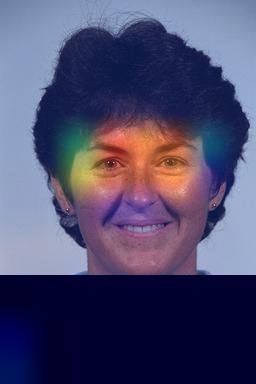

(384, 256, 3)
1/1 [==============================] - 0s 227ms/step
0143 Predicted: [1]


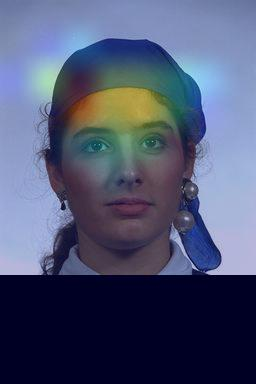

(384, 256, 3)
1/1 [==============================] - 0s 122ms/step
0139 Predicted: [0]


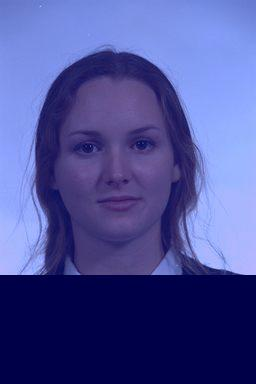

(384, 256, 3)
1/1 [==============================] - 0s 158ms/step
0035 Predicted: [0]


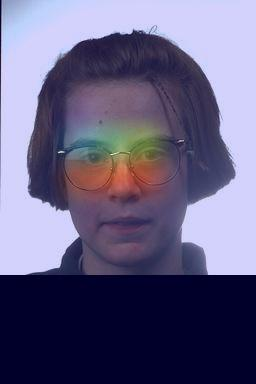

(384, 256, 3)
1/1 [==============================] - 0s 133ms/step
0031 Predicted: [0]


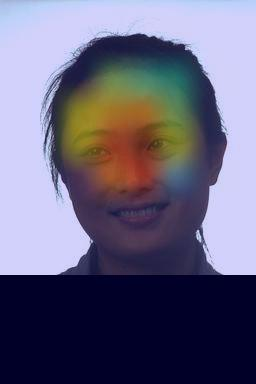

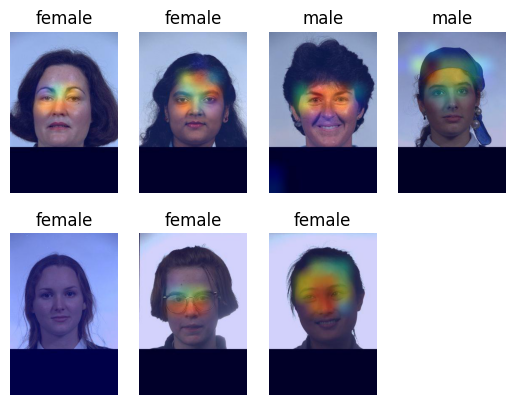

In [ ]:
def black_out_buttons_experiment(button_women):
  os.chdir("/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET-PROCESSED/test_set/female")
  i = 0
  while (i < 4):
    for woman in button_women:
      img_path = woman + ".thumbnail.jpg"
      im = PIL.Image.open(img_path)
      img_array = tf.keras.utils.img_to_array(im)
      print(np.shape(img_array))
      width, height = im.size

      # Black out bottom 35% of image to cover button
      for channel in range(3):
        for row in range(height - int(height / 3.5), height):
          for col in range(width):
            img_array[row][col][channel] = 0

      # Expand to batch size of 1
      img_array = np.expand_dims(img_array, axis=0)

      # Print what the top predicted class is
      preds = final_model.predict(img_array).flatten()
      preds = tf.nn.sigmoid(preds)
      preds = tf.where(preds < 0.5, 0, 1)

      print(woman, "Predicted:", preds.numpy())

      heatmap = make_gradcam_heatmap(img_array, final_model, last_conv_layer_name)
      save_and_display_gradcam(img_path, heatmap, flip=False, black_out=True)

      ax = plt.subplot(2, 4, i + 1)
      im = PIL.Image.open("/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET-PROCESSED/test_set/female/cam.jpg")
      plt.imshow(im)

      if preds.numpy()[0] == 1:
        label = "male"
        plt.title("male")
      else:
        label = "female"
        plt.title("female")

      plt.axis("off")
      i += 1
  return

black_out_buttons_experiment(button_women)

Blacking out the collar and/or button area results in five out of seven women being classified correctly.